# train 후 evalutation 코드
190603

In [1]:
# coding=utf-8
from datetime import datetime
import torch
import _pickle as cPickle
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

from loader import *
from utils import *

In [10]:
class Myconfig():
    def __init__(self):
        self.train        = 'data/eng.train'  # Train set location
        self.dev          = 'data/eng.testa'  # Dev set location
        self.test         = 'data/eng.testb'  # Test set location
        
        self.score        = 'evaluation/temp/score.txt'  # score file location
        self.crf          = 0  # Use CRF (0 to disable)
         
        self.use_gpu      = 1  # whether or not to ues gpu
        self.loss         = 'loss.txt'  # loss file location
        self.map_path     = 'models/mapping.pkl'  # model path
        self.char_mode    = 'CNN'  # ['CNN', 'LSTM']  # char_CNN or char_LSTM
        self.models_path  = "models"
        self.name         = 'lstm_crf.model'  # model name
        self.model_name   = os.path.join(self.models_path, self.name)
        self.eval_path    = "evaluation"
        self.eval_temp    = os.path.join(self.eval_path, "temp")
        self.eval_script  = os.path.join(self.eval_path, "conlleval")
        
opts = Myconfig()
def _print_config(config):
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(vars(config))
_print_config(opts)

{   'char_mode': 'CNN',
    'crf': 0,
    'dev': 'data/eng.testa',
    'eval_path': 'evaluation',
    'eval_script': 'evaluation/conlleval',
    'eval_temp': 'evaluation/temp',
    'loss': 'loss.txt',
    'map_path': 'models/mapping.pkl',
    'model_name': 'models/lstm_crf.model',
    'models_path': 'models',
    'name': 'lstm_crf.model',
    'score': 'evaluation/temp/score.txt',
    'test': 'data/eng.testb',
    'train': 'data/eng.train',
    'use_gpu': 1}


In [3]:
with open(opts.map_path, 'rb') as f:
    mappings = cPickle.load(f)

gpu 사용!


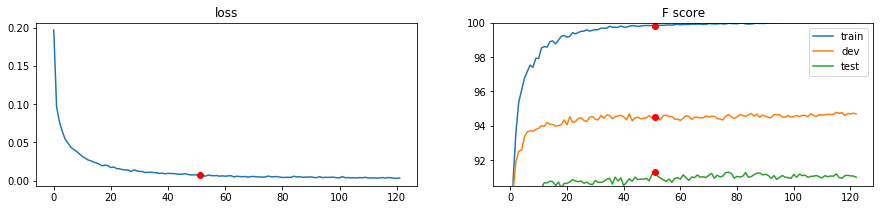

In [4]:
word_to_id  = mappings['word_to_id']
tag_to_id   = mappings['tag_to_id']
id_to_tag   = {k[1]: k[0] for k in tag_to_id.items()}
char_to_id  = mappings['char_to_id']
parameters  = mappings['parameters']
word_embeds = mappings['word_embeds']
epoch_losses= mappings['epoch_losses']
all_F       = mappings['all_F']

lower = parameters.lower
zeros = parameters.zeros
tag_scheme = parameters.tag_scheme

if opts.use_gpu == 1 and torch.cuda.is_available():  print('gpu 사용!')
else: opts.use_gpu = 0;    print('gpu 사용 불가!!')
    
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses)
plt.plot(parameters.best_idx, epoch_losses[parameters.best_idx], 'ro')
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(all_F)
plt.plot([parameters.best_idx, parameters.best_idx, parameters.best_idx], all_F[parameters.best_idx], 'ro')
plt.title('F score')
plt.legend(['train', 'dev', 'test'])
plt.ylim([90.5, 100])
plt.show()

In [5]:
assert os.path.isfile(opts.test)
assert parameters.tag_scheme in ['iob', 'iobes']

if not os.path.isfile(opts.eval_script):
    raise Exception('CoNLL evaluation script not found at "%s"' % eval_script)
if not os.path.exists(opts.eval_temp):
    os.makedirs(opts.eval_temp)

In [6]:
test_sentences = load_sentences(opts.test, lower, zeros)
update_tag_scheme(test_sentences, tag_scheme)
test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, lower
)

In [7]:
model = torch.load(opts.model_name)
model_name = opts.model_name.split('/')[-1].split('.')[0]

if opts.use_gpu:
    model.cuda()
model.eval()

BiLSTM_CRF(
  (char_embeds): Embedding(85, 25)
  (char_cnn3): Conv2d(1, 25, kernel_size=(3, 25), stride=(1, 1), padding=(2, 0))
  (word_embeds): Embedding(400176, 100)
  (dropout): Dropout(p=0.5)
  (lstm): LSTM(125, 200, bidirectional=True)
  (hw_trans): Linear(in_features=25, out_features=25, bias=True)
  (hw_gate): Linear(in_features=25, out_features=25, bias=True)
  (h2_h1): Linear(in_features=400, out_features=200, bias=True)
  (tanh): Tanh()
  (hidden2tag): Linear(in_features=400, out_features=19, bias=True)
)

In [8]:
def evaluating(model, datas, display_confusion_matrix = False):
    start_time = datetime.now();print('training start -%s' % start_time);
    prediction = []
    save = False
    new_F = 0.0
    confusion_matrix = torch.zeros((len(tag_to_id) - 2, len(tag_to_id) - 2))  # tag들의 갯수 - 2(start, stop)
    for data in datas:
        ground_truth_id = data['tags']
        words    = data['str_words'] # ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
        chars2   = data['chars']     # [[36, 58], [7, 1, 62, 1, 12, 3, 8], ...
        caps     = data['caps']      # [1, 0, 2, 0, 0, 0, 2, 0, 0]

        ## char embedding
        if opts.char_mode == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            matching_char = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in matching_char and not i in matching_char.values():
                        matching_char[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        if opts.char_mode == 'CNN':
            matching_char = {}
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        eval_sentence_in = Variable(torch.LongTensor(data['words']))
        eval_caps  = Variable(torch.LongTensor(caps))
        # 변수들 gpu로 보내기
        if opts.use_gpu:
            eval_sentence_in= eval_sentence_in.cuda()
            chars2_mask     = chars2_mask.cuda()
            eval_caps       = eval_caps.cuda()
        ############################################################################
        ## !! inference!!
        ## input : 문장, caption, 단어들, 단어길이들, 단어매칭dict
        ## output: score : tensor(237.0103, device='cuda:0', grad_fn=<SelectBackward>)
        ##         target_sequence : [4, 0, 5, 0, 0, 0, 5, 0, 0]
        ############################################################################
        score, predict_target_sequence = model(sentence= eval_sentence_in,
                                               caps    = eval_caps,                             
                                               chars        = chars2_mask,
                                               chars2_length= chars2_length,
                                               matching_char= matching_char)  # target이 없다.
        predicted_id = predict_target_sequence    
        # word, true_id, pred_id
        # 단어,    정답, 예측값
        # EU       4     4
        # rejects  0     0
        # German   5     5
        # call     0     0
        # to       0     0
        # boycott  0     0
        # British  5     5
        # lamb     0     0
        # .        0     0
        for (word, true_id, pred_id) in zip(words, ground_truth_id, predicted_id):
            line = ' '.join([word, id_to_tag[true_id], id_to_tag[pred_id]])
            prediction.append(line)
            confusion_matrix[true_id, pred_id] += 1 # 17 x 17 행렬에서, [실제값, 예측값] 부분에 +1 추가
        prediction.append('')
    predf  = opts.eval_temp + '/pred.' + opts.name
    scoref = opts.eval_temp + '/score.' + opts.name 
    
    ## inference 출력!!!! - /evaluation/temp/pred.test
    ## word   true   prediction
    ## prediction
    # EU S-ORG O
    # rejects O O
    # German S-MISC O
    # call O O
    with open(predf, 'w') as f:
        f.write('\n'.join(prediction))
    # evaluation 폴더에 있는 conlleval 파일을 실행시킨다.
    # 공식으로 제공하는 평가 및 저장 코드가 있다.
    # system 명령어로 구동 - 'evaluation/conlleval < evaluation/temp/pred.test > evaluation/temp/score.test'
    os.system('%s < %s > %s' % (opts.eval_script, predf, scoref))
    ############################################################################
    ## display
    ############################################################################
    # 위 명령어로 평가가 진행되고 'scoref' 경로에 socre가 저장된다
    # best f1 score를 갱신하면, save=True를 return 하고 저장하도록 한다
    eval_lines = [l.rstrip() for l in codecs.open(scoref, 'r', 'utf8')]
    for i, line in enumerate(eval_lines):
        print(line)
#         if i == 1:
#             new_F = float(line.strip().split()[-1])
#             if new_F > best_F:
#                 best_F = new_F
#                 save = True
#                 print('the best F is ', new_F)
    ############################################################################
    ## display, confusion matrix
    ############################################################################
    if display_confusion_matrix:
        print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >6}" * confusion_matrix.size(0))).format(
                "ID", "NE", "Total",
                *([id_to_tag[i] for i in range(confusion_matrix.size(0))] + ["Percent"])
                ))
        for i in range(confusion_matrix.size(0)):
            print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >6}" * confusion_matrix.size(0))).format(
                    str(i), id_to_tag[i], str(int(confusion_matrix[i].sum())),
                    *([int(confusion_matrix[i][j]) for j in range(confusion_matrix.size(0))] +
                      ["%.2f" % (confusion_matrix[i][i] * 100. / max(1, confusion_matrix[i].sum()))])
                    ))
    return start_time

In [9]:
start_time = evaluating(model, test_data, display_confusion_matrix=True)
print('\n소요시간 : %s' % ((datetime.now() - start_time)))

training start -2019-06-04 10:54:48.862463
processed 46435 tokens with 5628 phrases; found: 5648 phrases; correct: 5142.
accuracy:  97.93%; precision:  91.04%; recall:  91.36%; FB1:  91.20
              LOC: precision:  92.00%; recall:  94.10%; FB1:  93.04  1700
             MISC: precision:  80.68%; recall:  81.96%; FB1:  81.32  704
              ORG: precision:  89.91%; recall:  88.77%; FB1:  89.33  1635
              PER: precision:  95.71%; recall:  95.24%; FB1:  95.47  1609
ID     NE  Total     O S-LOC B-PER E-PER S-ORGS-MISC B-ORG E-ORG S-PER I-ORG B-LOC E-LOCB-MISCE-MISCI-MISC I-PER I-LOC  Percent
 0      O  38323 38054    18     5     4    23    20    12    24    10    18     7     9    43    57    15     0     4    99.30
 1  S-LOC   1436    10  1345     2     1    30    16     5     3     2     2     4     3    12     1     0     0     0    93.66
 2  B-PER   1086     2     0  1076     0     0     0     4     0     0     1     1     0     0     0     0     2     0    99.08
 3  